# Stitching a VBI Moasic with `reproject`

The [reproject](https://reproject.readthedocs.io/) package is an Astropy-affiliated package for regridding data.
A number of different algorithms are implemented in the package, with different trade-offs for speed and accuracy.
Reprojecting a single spatial image such as an AIA image is well supported and demonstrated in the [sunpy gallery](https://docs.sunpy.org/en/latest/generated/gallery/index.html#combining-co-aligning-and-reprojecting-images).
When working with DKIST data, there are normally many spatial frames inside a dataset, and reprojecting them all can be very computationally expensive.

We are going to use the example of using reproject's {obj}`reproject.mosaicking.reproject_and_coadd` function to stitch a mosaic of VBI frames, in a way which could be extended to be flux conserving.


## Obtaining some data

In [3]:
import dkist
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [5]:
ds = dkist.Dataset.from_directory("~/sunpy/data/VBI/BLKGA")

This mosaic is 3 x 3:

In [6]:
ds.shape

(3, 3)

To start off, let's just download the first frame of each tile.

In [7]:
first_tiles = [tile[0] for tile in ds.flat]

In [8]:
for i, tile in enumerate(first_tiles):
    tile.files.download(wait=False)

We can now make a composite plot of all the tiles.

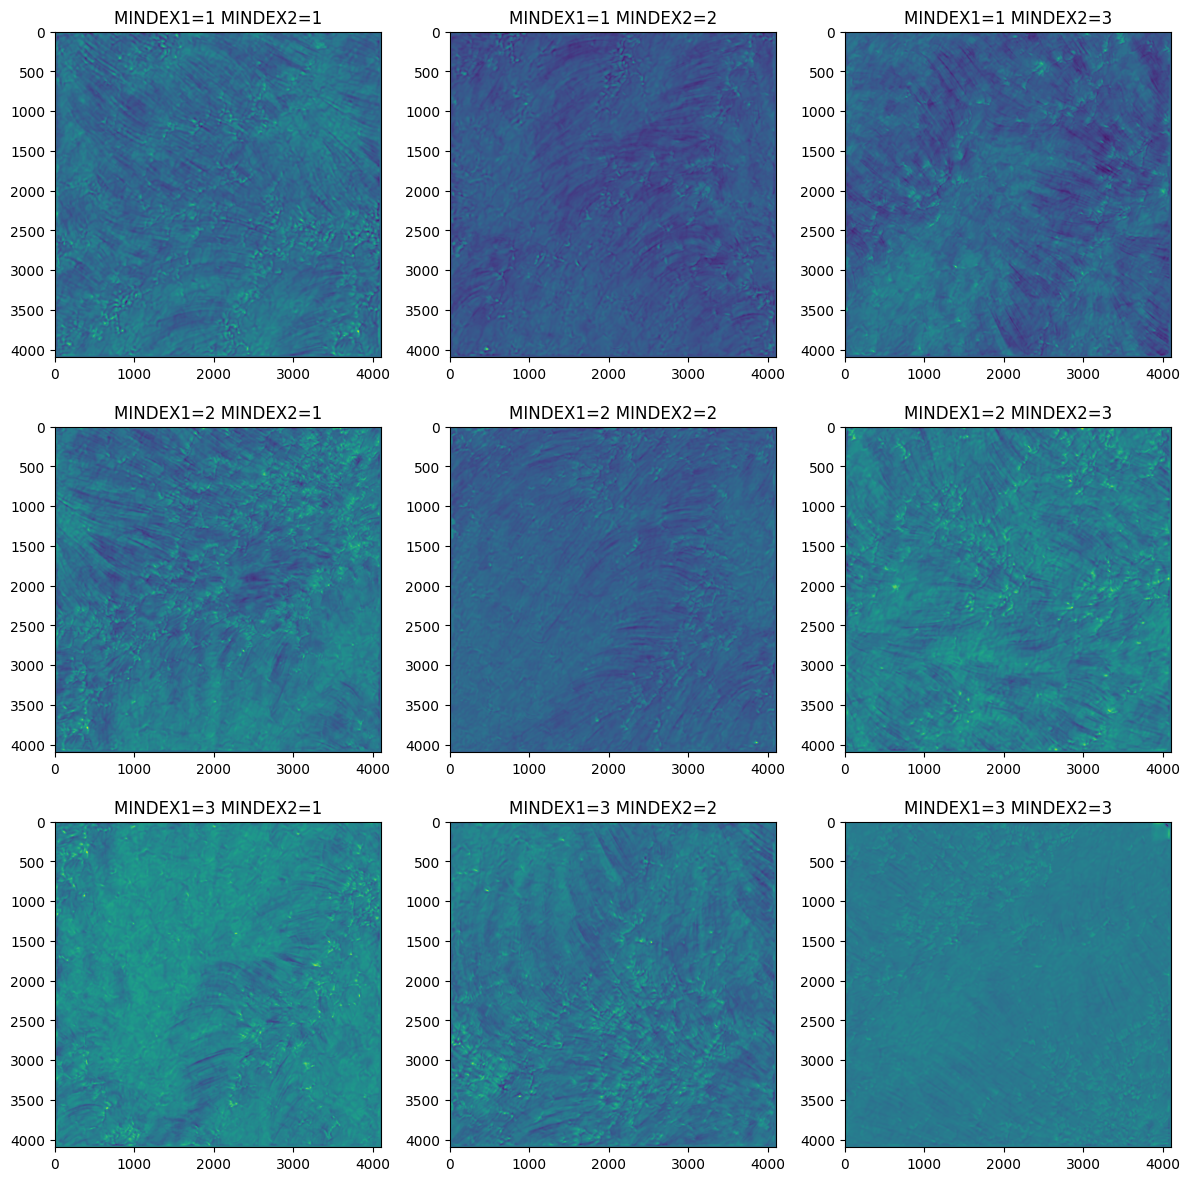

In [10]:
fig = plt.figure(figsize=(12, 12))

for i, tile in enumerate(first_tiles):
    ax = fig.add_subplot(ds.shape[1], ds.shape[0], i + 1)
    ax.set_title(f"MINDEX1={tile.headers[0]['MINDEX1']} MINDEX2={tile.headers[0]['MINDEX2']}")
    ax.imshow(tile.data)

fig.tight_layout()

## Regridding with Reproject

First, we need the most recent version of reproject (released on Friday) for this to work, so let's check:

In [11]:
import reproject

Now import everything we need for it to run

In [14]:
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp, reproject_adaptive, reproject_exact
from ndcube import NDCube

First, let us crop off the edges of all our tiles to remove some artifacts.

In [16]:
first_tiles = [d[0, 100:-100, 100:-100] for d in ds.flat]

Next we need to calculate the optimal WCS for the output:

In [17]:
reference_wcs, shape_out = find_optimal_celestial_wcs(
    [f.wcs for f in first_tiles],
    auto_rotate=True,
)

Now we can do the actual reprojection

In [ ]:
arr, footprint = reproject_and_coadd(
    first_tiles,
    reference_wcs,
    reproject_function=reproject_interp,
    shape_out=shape_out,
    roundtrip_coords=False,
)

Make a new `NDCube` object and plot it.

In [ ]:
plt.figure(figsize=(10, 10))
stitched = NDCube(arr, reference_wcs)
stiched.plot()

We can see some small artifacting which can be hidden by using the `match_background=True` keyword argument to `reproject_and_coadd`.